In [1]:
import numpy as np
import pandas as pd
import glob
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import scipy as sp
import pingouin as pg
import seaborn as sns
import matplotlib
import os
import statsmodels.api as sm
from pingouin import partial_corr

## Read old CG files

In [2]:
def get_species_count(row):
    try:
        file_path = f'data_subsampled/{row["project"]}/{row["label"]}.csv'
        return pd.read_csv(file_path, index_col=0).values.shape[1]
    except FileNotFoundError:
        return np.nan  # or any other default value

In [3]:
import os

cg_old = []

cg_file = 'Data/sub_sampled_cg.json'

if os.path.exists(cg_file):
    with open(cg_file, 'r') as f:
        # Read the file line by line, treating each line as a separate JSON object
        for line in f:
            item = json.loads(line)
            cg_old.append(item)

## Read new cg, taylor, comp

In [4]:
cg_new = []

cg_file_new = 'Data/MB_100_subsampled_results/cg.json'

if os.path.exists(cg_file_new):
    with open(cg_file_new, 'r') as f:
        # Read the file line by line, treating each line as a separate JSON object
        for line in f:
            item = json.loads(line)
            cg_new.append(item)

taylor = []

taylor_file = 'Data/MB_100_subsampled_results/taylor.json'

if os.path.exists(taylor_file):
    with open(taylor_file, 'r') as f:
        # Read the file line by line, treating each line as a separate JSON object
        for line in f:
            item = json.loads(line)
            taylor.append(item)

comp_file = f'Data/comp_w_cutoff.json'
comp = pd.read_json(comp_file, lines=True)
comp['comp_2'] = comp['comp'].apply(lambda x: x[0])
comp['comp'] = comp['comp'].apply(lambda x: np.sum(x))

In [5]:
mb_metadata = pd.read_csv('/home/ks2823/Microbiomap/Data/sample_metadata.tsv', sep='\t')

mb_metadata = mb_metadata[['project', 'region']].drop_duplicates()
mb_metadata.describe()

,project,region
count,514,514
unique,482,9
top,PRJEB11419,Europe and Northern America
freq,9,276


In [7]:
mb_metadata

,project,region
0,PRJDB11894,Eastern and South-Eastern Asia
332,PRJDB11845,Eastern and South-Eastern Asia
435,PRJDB8511,Eastern and South-Eastern Asia
549,PRJDB10528,Eastern and South-Eastern Asia
869,PRJDB10527,Eastern and South-Eastern Asia
...,...,...
165884,PRJNA290926,Europe and Northern America
166887,PRJNA279031,Europe and Northern America
166937,PRJNA259224,Europe and Northern America
167232,PRJNA275256,Eastern and South-Eastern Asia


In [8]:
# Get unique values and their counts
unique, counts = np.unique(mb_metadata['project'], return_counts=True)

# Find projects that appear more than once
duplicate_projects = unique[counts > 1]
unique_projects = unique[counts == 1]

# Filter the dataframe to show only duplicate entries
mb_metadata = mb_metadata[mb_metadata['project'].isin(unique_projects)]

In [9]:
mb_metadata

,project,region
0,PRJDB11894,Eastern and South-Eastern Asia
332,PRJDB11845,Eastern and South-Eastern Asia
435,PRJDB8511,Eastern and South-Eastern Asia
549,PRJDB10528,Eastern and South-Eastern Asia
869,PRJDB10527,Eastern and South-Eastern Asia
...,...,...
165393,PRJNA306884,Europe and Northern America
166887,PRJNA279031,Europe and Northern America
166937,PRJNA259224,Europe and Northern America
167232,PRJNA275256,Eastern and South-Eastern Asia


In [10]:
cg_old = pd.DataFrame(cg_old)
cg_new = pd.DataFrame(cg_new)
taylor = pd.DataFrame(taylor)

print(cg_old.shape)
print(cg_new.shape)
print(taylor.shape)
print(comp.shape)

(4810, 3)
(3060, 3)
(3060, 2)
(4323, 3)


In [11]:
m_df = pd.merge(cg_new, taylor, on='label')
m_df = pd.merge(m_df, comp, on='label')
# print(m_df.head())

m_df['project'] = m_df['label'].apply(lambda x: x.split('_')[0])

m_df['species_count'] = m_df[['project', 'label']].apply(get_species_count, axis=1)

m_df = m_df.drop(columns=['label'])
# print(m_df.head())
m_df = m_df.groupby('project').apply(lambda x: x.mean()).reset_index()

common_projects = np.intersect1d(mb_metadata['project'], m_df['project'])
print(len(common_projects))

m_df = pd.merge(m_df, mb_metadata, on='project', how='inner')
print(m_df.head())

263
      project    exp_cg  mean_retain_null  Taylor_slope      comp    comp_2  \
0  PRJDB10485  0.287460          0.174970      1.668182  4.292184  0.980632   
1  PRJDB10528  0.265498          0.168350      1.496769  5.161410  1.043566   
2  PRJDB10612  0.368279          0.196280      1.438723  3.957034  0.996750   
3  PRJDB11845  0.195945          0.124937      1.437620  4.690277  1.024454   
4  PRJDB11894  0.206591          0.130038      1.569955  4.265537  1.031119   

   species_count                          region  
0           60.3              Sub-Saharan Africa  
1           77.2  Eastern and South-Eastern Asia  
2           44.5                         unknown  
3           99.6  Eastern and South-Eastern Asia  
4           81.3  Eastern and South-Eastern Asia  


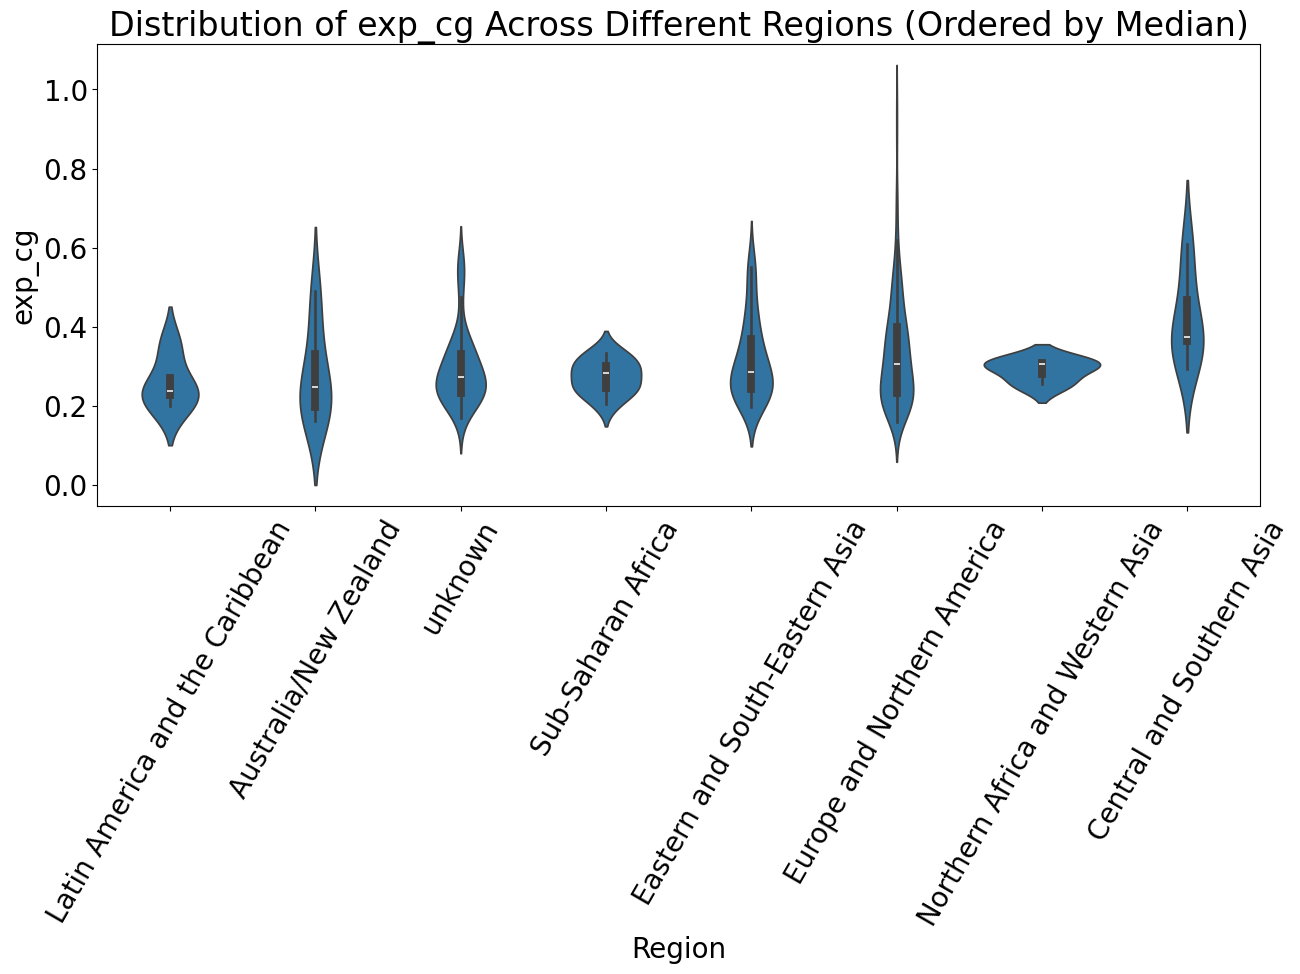

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute medians of exp_cg for each region
region_order = m_df.groupby('region')['exp_cg'].median().sort_values().index

# Plot violin plot with ordered x-axis
plt.figure(figsize=(15, 6))
sns.violinplot(x='region', y='exp_cg', data=m_df, order=region_order)

# Improve readability
plt.xticks(rotation=60)
plt.title("Distribution of exp_cg Across Different Regions (Ordered by Median)")
plt.xlabel("Region")
plt.ylabel("exp_cg")

plt.show()

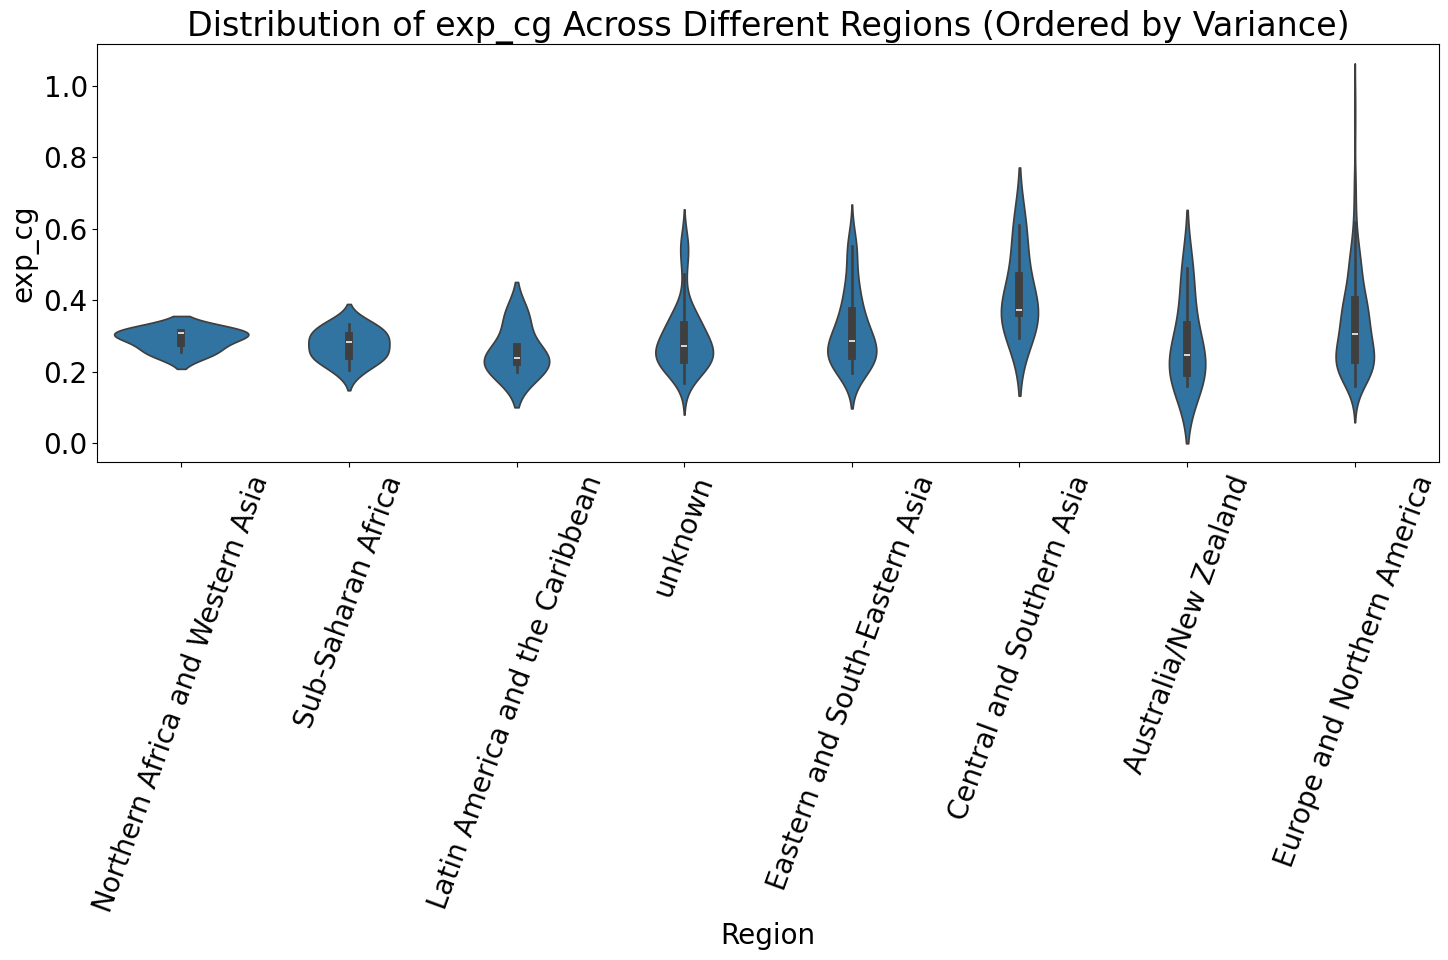

In [12]:
# Compute variance of exp_cg for each region
region_order = m_df.groupby('region')['exp_cg'].var().sort_values().index

# Plot violin plot with ordered x-axis
plt.figure(figsize=(15, 10))
sns.violinplot(x='region', y='exp_cg', data=m_df, order=region_order)

# Improve readability
plt.xticks(rotation=70)
plt.title("Distribution of exp_cg Across Different Regions (Ordered by Variance)")
plt.xlabel("Region")
plt.ylabel("exp_cg")

plt.tight_layout()
plt.savefig('/home/ks2823/Microbiomap/Pictures/LD_by_region.pdf', format='pdf')
plt.show()

In [13]:
region_order

Index(['Northern Africa and Western Asia', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'unknown',
       'Eastern and South-Eastern Asia', 'Central and Southern Asia',
       'Australia/New Zealand', 'Europe and Northern America'],
      dtype='object', name='region')

In [14]:
from scipy.stats import mannwhitneyu
from itertools import combinations

regions = region_order

for r1, r2 in combinations(regions, 2):
    stat, p = mannwhitneyu(m_df[m_df['region'] == r1]['exp_cg'], m_df[m_df['region'] == r2]['exp_cg'])
    if p <= 0.05:
        print(f"{r1} vs {r2}: \np-value = {p}")

Sub-Saharan Africa vs Central and Southern Asia: 
p-value = 0.002797202797202797
Latin America and the Caribbean vs Central and Southern Asia: 
p-value = 0.01904761904761905
unknown vs Central and Southern Asia: 
p-value = 0.004177294068221935
Eastern and South-Eastern Asia vs Central and Southern Asia: 
p-value = 0.03443903421214822


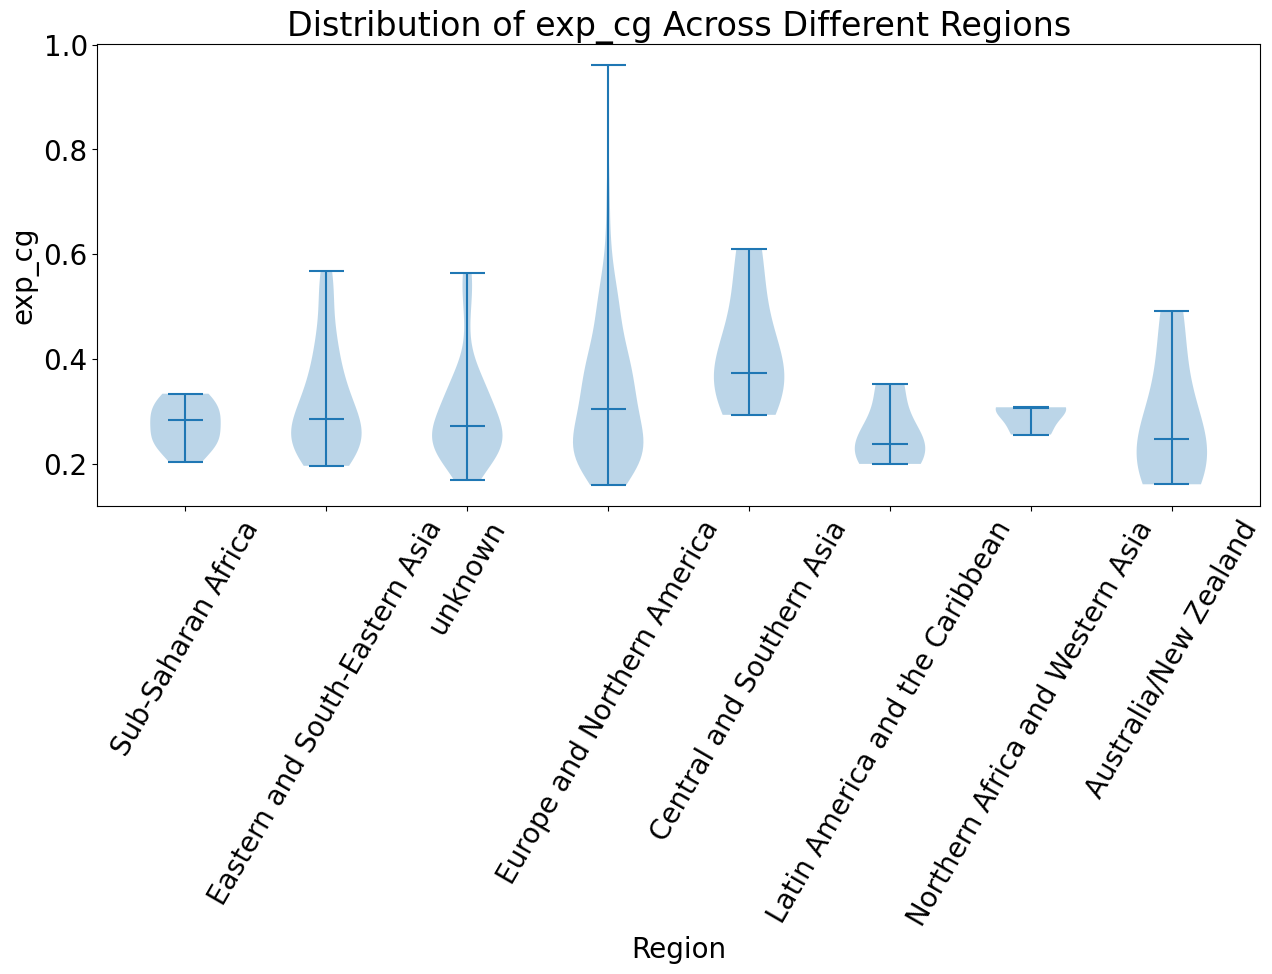

In [15]:
# Group exp_cg values by unique regions
regions = m_df['region'].unique()
data = [m_df[m_df['region'] == region]['exp_cg'].values for region in regions]

# Create the violin plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data, positions=np.arange(len(regions)), showmedians=True, showextrema=True)

# Customize the plot
ax.set_xticks(np.arange(len(regions)))
ax.set_xticklabels(regions, rotation=60)  # Rotate labels for better readability
ax.set_xlabel("Region")
ax.set_ylabel("exp_cg")
ax.set_title("Distribution of exp_cg Across Different Regions")

plt.show()

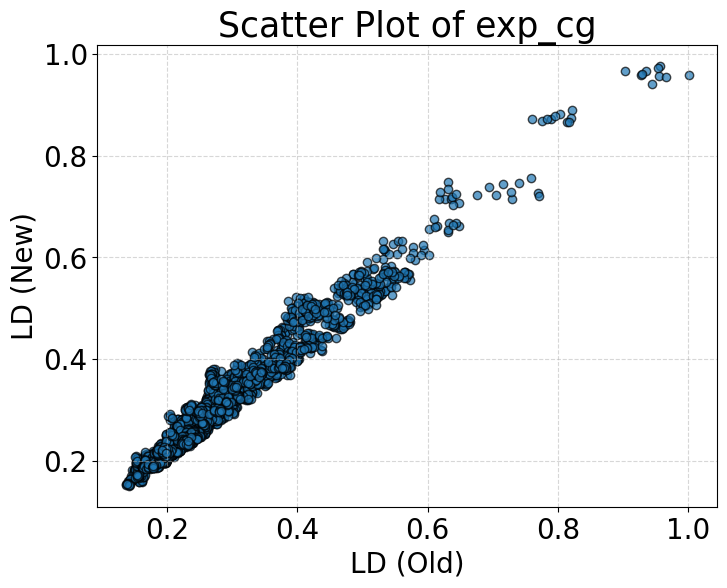

In [13]:
new_old = pd.merge(cg_old[['label', 'exp_cg']], cg_new[['label', 'exp_cg']], on='label', suffixes=('_old', '_new'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(new_old['exp_cg_old'], new_old['exp_cg_new'], alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of exp_cg', fontsize=25)
plt.xlabel('LD (Old)')
plt.ylabel('LD (New)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [14]:
m_df.head()

,project,exp_cg,mean_retain_null,Taylor_slope,comp,comp_2,species_count,region
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,0.980632,60.3,Sub-Saharan Africa
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,1.043566,77.2,Eastern and South-Eastern Asia
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,0.996750,44.5,unknown
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,1.024454,99.6,Eastern and South-Eastern Asia
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,1.031119,81.3,Eastern and South-Eastern Asia


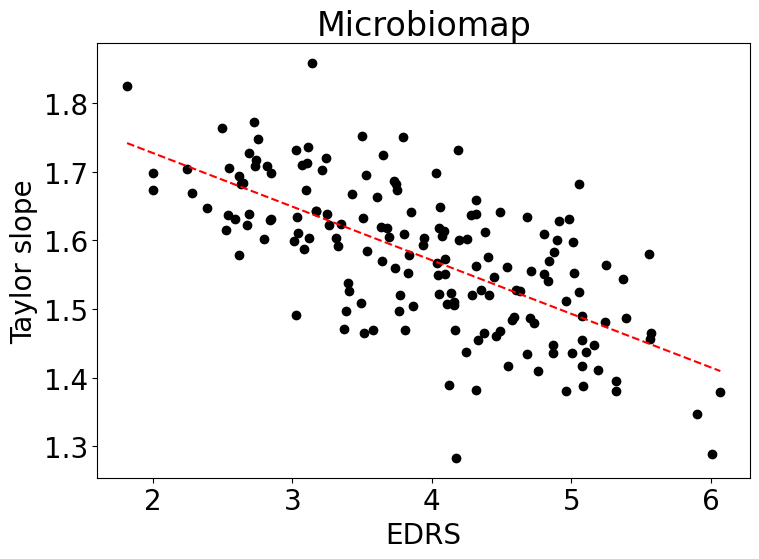

SignificanceResult(statistic=-0.6711348387562226, pvalue=4.429122351199691e-23)
Slope: -0.07810364208723108


In [15]:
x = 1/m_df['exp_cg']
y = m_df['Taylor_slope']
mask = m_df['species_count'] >= 70

plt.figure(figsize=(8, 6))
plt.scatter(x[mask], y[mask], color='black')

# Fit a line (degree 1 polynomial) to the data
coefficients = np.polyfit(x[mask], y[mask], 1)  # Linear fit
slope, intercept = coefficients

# Create points for the fitted line
x_line = np.linspace(min(x[mask]), max(x[mask]), 100)
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='red', label=f'Slope: {slope:.2f}', linestyle='--')
plt.xlabel('EDRS')
plt.ylabel('Taylor slope')
plt.title('Microbiomap')
plt.tight_layout()
plt.savefig('Pictures/Microbioma_taylor_edrs.pdf', format='pdf')
plt.show()

print(sp.stats.spearmanr(x[mask], y[mask]))
print("Slope:", slope)

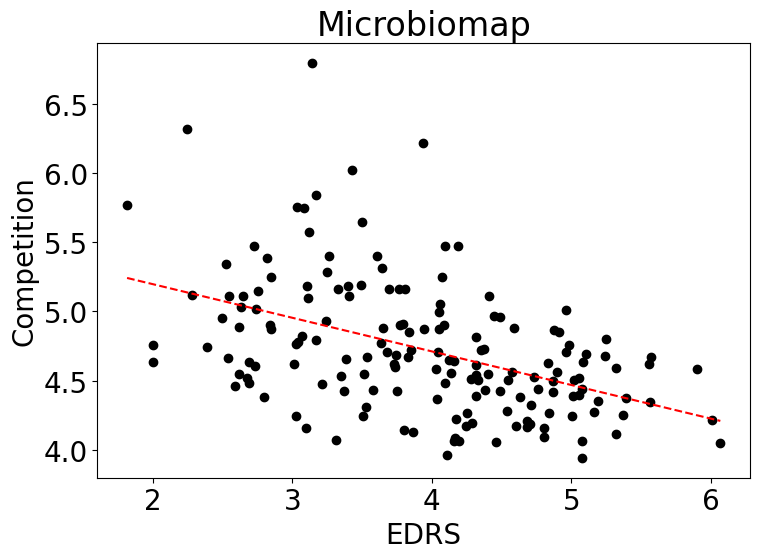

SignificanceResult(statistic=-0.47884384571492294, pvalue=6.764956942583852e-11)
Slope: -0.2423482717138283


In [17]:
x = 1/m_df['exp_cg']
y = m_df['comp']
mask = m_df['species_count'] >= 70

plt.figure(figsize=(8, 6))
plt.scatter(x[mask], y[mask], color='black')

# Fit a line (degree 1 polynomial) to the data
coefficients = np.polyfit(x[mask], y[mask], 1)  # Linear fit
slope, intercept = coefficients

# Create points for the fitted line
x_line = np.linspace(min(x[mask]), max(x[mask]), 100)
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='red', label=f'Slope: {slope:.2f}', linestyle='--')
plt.xlabel('EDRS')
plt.ylabel('Competition')
plt.title('Microbiomap')
plt.tight_layout()
# plt.savefig('Pictures/Microbiomap_comp_edrs.pdf', format='pdf')

plt.show()

print(sp.stats.spearmanr(x[mask], y[mask]))
print("Slope:", slope)

### Checkpoint

In [21]:
m_df.to_csv('/home/ks2823/Microbiomap/checkpoints/m_df_1.csv')

# Participation ratio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

def plot_helper(x, y, x_label=None, y_label=None, title=None):
    """
    Plots scatter + linear trend line + 95% confidence interval only.

    Args:
        x (array-like): x‑values
        y (array-like): y‑values
        x_label (str): x‑axis label
        y_label (str): y‑axis label
        title   (str): plot title
    """
    # Convert to arrays for positional indexing
    x = np.asarray(x)
    y = np.asarray(y)
    
    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]

    # Spearman correlation
    spearman, pval = sp.stats.spearmanr(x, y)
    print(f'Spearman R: {spearman:.3f}, P‑value: {pval:.3f}')

    # Fit linear model
    X       = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    pred    = results.get_prediction(X).summary_frame(alpha=0.05)

    # Sort for plotting
    idx       = np.argsort(x)
    x_sorted  = x[idx]
    y_sorted  = y[idx]
    pf_sorted = pred.iloc[idx]

    # Extract mean and confidence limits
    ci_low, ci_high = pf_sorted['mean_ci_lower'], pf_sorted['mean_ci_upper']
    y_pred          = pf_sorted['mean']

    # Plot
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,6))

    # 95% confidence interval
    plt.fill_between(x_sorted, ci_low, ci_high,
                     alpha=0.5, label='95% confidence interval')

    # Data & trend line
    plt.scatter(x_sorted, y_sorted, color='black', label='Data')
    plt.plot(x_sorted, y_pred, color='red', linestyle='--',
             label=f'Linear fit (Spearman R={spearman:.2f})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    # plt.show()


In [3]:
pr_df = pd.read_json('Data/MB_100_subsampled_results/exponent_pr.json', lines=True)
pr_df['project'] = pr_df['label'].apply(lambda x: x.split('_')[0])
pr_df = pr_df.drop(columns=['label'])
pr_df = pr_df.groupby('project', as_index=False).mean()
pr_df['pr_corrected'] = -(pr_df['pr_null'] - pr_df['pr'])
pr_df['se_corrected'] = -(pr_df['se_null'] - pr_df['se'])
pr_df['z_pr_corrected'] = -(pr_df['z_pr_null'] - pr_df['z_pr'])
pr_df['z_se_corrected'] = -(pr_df['z_se_null'] - pr_df['z_se'])

pr_df = pr_df.drop(columns=['pr_null', 'se_null', 'z_pr_null', 'z_se_null', 'z_pr', 'z_se', 'z_pr_corrected', 'z_se_corrected'])

m_df = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/m_df_2.csv', index_col=0)
m_df = m_df.drop(columns=['region', 'exp_cg', 'species_count'])
m_df['END_null'] = m_df['mean_retain_null'].apply(lambda x: 1/x)
m_df['END_corrected'] = m_df['END_null']*m_df['END']/(m_df['END_null'] - m_df['END'])
combined_df = pd.merge(pr_df, m_df, on='project', how='outer')
combined_df.head()

theta_df = pd.read_json('/home/ks2823/Microbiomap/Data/MB_100_subsampled_results/theta_scaled_results.json', lines=True)
theta_df['project'] = theta_df['label'].apply(lambda x: x.split('_')[0])
theta_df = theta_df.drop(columns=['label'])
theta_df = theta_df.groupby('project', as_index=False).mean()
theta_df = theta_df.rename(columns={'comp':'theta_comp', 'comp_null_s': 'theta_comp_null_s', 'comp_null_r':'theta_comp_null_r', 'generalists':'theta_generalists_pr', 'generalists_null':'theta_generalists_pr_null'})
theta_df['theta_comp_corrected'] = theta_df['theta_comp']/theta_df['theta_comp_null_r'] - 1
theta_df['theta_generalists_corrected'] = theta_df['theta_generalists_pr']/theta_df['theta_generalists_pr_null'] - 1
combined_df = pd.merge(combined_df, theta_df, on='project', how='outer')

load = pd.read_csv('Data/MB_100_subsampled_results/microbiomap_load.csv')
load['project'] = load['project_i'].apply(lambda x: x.split('_')[0])
load.drop('project_i', axis=1, inplace=True)
for col in ['mean_load', 'var_load']:
    load[col] = pd.to_numeric(load[col], errors='coerce')
load['log_mean_load'] = np.log(load['mean_load'])
load['log_var_load'] = np.log(load['var_load'])
load['mean_removed_load'] = load['mean_load'] - load['mean_load'].mean()
load = load.groupby('project', as_index=False).mean()
combined_df = combined_df.merge(load, on='project', how='outer')
combined_df.head()

,project,pr,se,pr_corrected,se_corrected,mean_retain_null,Taylor_slope,comp,generalists,END,...,theta_comp_null_r,theta_generalists_pr,theta_generalists_pr_null,theta_comp_corrected,theta_generalists_corrected,mean_load,var_load,log_mean_load,log_var_load,mean_removed_load
0,PRJDB10485,2.358878,1.643486,-0.083514,-0.078072,0.174970,1.668182,4.292184,1.113747,3.478749,...,0.977179,1.000199,1.000101,0.000472,0.000098,4.990292e+10,4.184842e+19,24.633324,45.178325,-3.340917e+09
1,PRJDB10528,2.155223,1.544880,-0.081010,-0.064338,0.168350,1.496769,5.161410,0.450466,3.766504,...,0.984264,1.000542,1.000241,-0.000785,0.000301,6.107036e+10,1.834771e+20,24.835198,46.652636,7.826517e+09
2,PRJDB10612,2.117780,1.481253,-0.137890,-0.137479,0.196280,1.438723,3.957034,0.621642,2.715330,...,0.980093,0.998157,0.999138,-0.000283,-0.000981,4.918380e+10,4.629559e+19,24.618825,45.281003,-4.060041e+09
3,PRJDB11845,2.157682,1.548282,0.045151,0.008676,0.124937,1.437620,4.690277,0.488290,5.103462,...,0.984533,0.999554,0.999717,-0.000823,-0.000162,6.124416e+10,1.853193e+20,24.838126,46.667744,8.000314e+09
4,PRJDB11894,2.302838,1.629094,0.042373,0.003314,0.130038,1.569955,4.265537,0.630050,4.840477,...,0.980895,0.999916,1.000041,-0.000762,-0.000125,5.888572e+10,1.208727e+20,24.798854,46.240588,5.641876e+09


In [4]:
combined_df.to_csv('/home/ks2823/Microbiomap/checkpoints/combined_df.csv')

# Checkpoint

In [5]:
combined_df = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/combined_df.csv', index_col=0)
combined_df.head()

,project,pr,se,pr_corrected,se_corrected,mean_retain_null,Taylor_slope,comp,generalists,END,...,theta_comp_null_r,theta_generalists_pr,theta_generalists_pr_null,theta_comp_corrected,theta_generalists_corrected,mean_load,var_load,log_mean_load,log_var_load,mean_removed_load
0,PRJDB10485,2.358878,1.643486,-0.083514,-0.078072,0.174970,1.668182,4.292184,1.113747,3.478749,...,0.977179,1.000199,1.000101,0.000472,0.000098,4.990292e+10,4.184842e+19,24.633324,45.178325,-3.340917e+09
1,PRJDB10528,2.155223,1.544880,-0.081010,-0.064338,0.168350,1.496769,5.161410,0.450466,3.766504,...,0.984264,1.000542,1.000241,-0.000785,0.000301,6.107036e+10,1.834771e+20,24.835198,46.652636,7.826517e+09
2,PRJDB10612,2.117780,1.481253,-0.137890,-0.137479,0.196280,1.438723,3.957034,0.621642,2.715330,...,0.980093,0.998157,0.999138,-0.000283,-0.000981,4.918380e+10,4.629559e+19,24.618825,45.281003,-4.060041e+09
3,PRJDB11845,2.157682,1.548282,0.045151,0.008676,0.124937,1.437620,4.690277,0.488290,5.103462,...,0.984533,0.999554,0.999717,-0.000823,-0.000162,6.124416e+10,1.853193e+20,24.838126,46.667744,8.000314e+09
4,PRJDB11894,2.302838,1.629094,0.042373,0.003314,0.130038,1.569955,4.265537,0.630050,4.840477,...,0.980895,0.999916,1.000041,-0.000762,-0.000125,5.888572e+10,1.208727e+20,24.798854,46.240588,5.641876e+09


### Get generalists results

In [3]:
gen_df = pd.read_json('/home/ks2823/Microbiomap/Data/MB_100_subsampled_results/generalists_100_individual_bacteria.json', lines=True)

# Drop 'id_iter' since it's not needed
gen_df = gen_df.drop(columns=['id_iter'])

# Group by 'label' and compute the mean for each numeric column
gen_df = gen_df.groupby('label', as_index=False).mean()

# Display the first few rows
gen_df.head()

,label,mean_num_resources,weighted_num_resources,weighted_to_mean_ratio,weighted_to_mean_diff,cosine_similarity
0,PRJDB10485_0,14.653827,17.834130,1.241306,3.180304,0.766735
1,PRJDB10485_1,16.348342,19.188385,1.169024,2.840043,0.771917
2,PRJDB10485_2,16.665973,17.530746,1.068011,0.864774,0.769942
3,PRJDB10485_3,15.773512,16.235108,1.027422,0.461596,0.769590
4,PRJDB10485_4,17.991576,20.819553,1.156105,2.827977,0.772819


In [4]:
gen_df.columns

Index(['label', 'mean_num_resources', 'weighted_num_resources',
       'weighted_to_mean_ratio', 'weighted_to_mean_diff', 'cosine_similarity'],
      dtype='object')

In [5]:
gen_df['project'] = gen_df['label'].apply(lambda x: x.split('_')[0])
gen_df = gen_df.drop(columns=['label', 'weighted_num_resources', 'weighted_to_mean_ratio', 'weighted_to_mean_diff', 'cosine_similarity'])
gen_df = gen_df.groupby('project', as_index=False).mean()
gen_df.head()

,project,mean_num_resources
0,PRJDB10485,16.429216
1,PRJDB10528,16.246929
2,PRJDB10612,13.304625
3,PRJDB11845,16.131800
4,PRJDB11894,15.014537


In [6]:
combined_df = pd.merge(combined_df, gen_df, on='project', how='outer')

In [7]:
combined_df.keys()

Index(['project', 'pr', 'se', 'pr_corrected', 'se_corrected',
       'mean_retain_null', 'Taylor_slope', 'comp', 'generalists', 'END',
       'alpha', 'beta', 'END_null', 'END_corrected', 'theta_comp',
       'theta_comp_null_s', 'theta_comp_null_r', 'theta_generalists_pr',
       'theta_generalists_pr_null', 'theta_comp_corrected',
       'theta_generalists_corrected', 'mean_load', 'var_load', 'log_mean_load',
       'log_var_load', 'mean_removed_load', 'mean_num_resources'],
      dtype='object')

In [8]:
print('########################################################')
print('Generalists vs NicheDim controlling for Shannon entropy')
print(pg.partial_corr(combined_df, x='END', y='generalists', covar='alpha', method='spearman'))
print('########################################################')
print('\n')
print('########################################################')
print('Shannon entropy vs NicheDim controlling for generalists')
print(pg.partial_corr(combined_df, x='END', y='alpha', covar='generalists', method='spearman'))
print('########################################################')


########################################################
Generalists vs NicheDim controlling for Shannon entropy
            n         r          CI95%     p-val
spearman  263 -0.190684  [-0.3, -0.07]  0.001934
########################################################


########################################################
Shannon entropy vs NicheDim controlling for generalists
            n         r         CI95%         p-val
spearman  263  0.826882  [0.78, 0.86]  6.062488e-67
########################################################


In [9]:
print('########################################################')
print('Niche overlap vs NicheDim')
print(pg.partial_corr(combined_df, x='END', y='comp', method='spearman'))
print('########################################################')
print('\n')
print('########################################################')
print('Shannon entropy vs NicheDim')
print(pg.partial_corr(combined_df, x='END', y='alpha', method='spearman'))
print('########################################################')
print('\n')
print('########################################################')
print('Generalists vs NicheDim')
print(pg.partial_corr(combined_df, x='END', y='generalists', method='spearman'))
print('########################################################')


########################################################
Niche overlap vs NicheDim
            n         r          CI95%         p-val
spearman  263 -0.398913  [-0.5, -0.29]  1.823920e-11
########################################################


########################################################
Shannon entropy vs NicheDim
            n         r         CI95%         p-val
spearman  263  0.823983  [0.78, 0.86]  2.424577e-66
########################################################


########################################################
Generalists vs NicheDim
            n         r           CI95%     p-val
spearman  263 -0.147571  [-0.26, -0.03]  0.016624
########################################################


In [6]:
def get_num_species(project):
    data = pd.read_csv(f'/home/ks2823/Microbiomap/post_process_projects/{project}.csv', index_col=0)
    return data.shape[1]
# combined_df['num_species'] = combined_df['project'].apply(get_num_species)
cg_file = pd.read_json('/home/ks2823/Microbiomap/Data/MB_100_subsampled_results/cg.json', lines=True)
cg_file['project'] = cg_file['label'].apply(lambda x: x.split('_')[0])
projects_w_100_samples = cg_file['project'].unique()
print(len(projects_w_100_samples))

num_species_dict = {'project': [],
                'num_species': []}
for project in projects_w_100_samples:
    num_species_dict['project'].append(project)
    num_species_dict['num_species'].append(get_num_species(project))

num_species_df = pd.DataFrame(num_species_dict)
projects_w_100_samples_and_70_species = num_species_df[num_species_df['num_species'] >= 70]['project']
projects_w_100_samples_wo_70_species = num_species_df[num_species_df['num_species'] < 70]['project']

np.random.seed(42)
projects_to_process = np.random.choice(projects_w_100_samples_and_70_species, 50, replace=False).tolist()
# projects_to_process.extend(np.random.choice(projects_w_100_samples_wo_70_species, 25, replace=False).tolist())

# projects_to_process = projects_to_process_1.extend(projects_to_process_2)
len(projects_to_process)

306


50

In [7]:
len(projects_w_100_samples_and_70_species)

201

In [12]:
mb_small = combined_df[np.isin(combined_df['project'], projects_w_100_samples_and_70_species)]

In [13]:
len(mb_small)

201

In [15]:
mb_small.to_csv('/home/ks2823/Microbiomap/checkpoints/mb_small.csv')

# MB small checkpoint

In [2]:
mb_small = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/mb_small.csv')

In [4]:
sp.stats.mannwhitneyu(mb_small['END'].dropna(), mb_small['END_null'].dropna())

MannwhitneyuResult(statistic=1002.0, pvalue=4.460922634672772e-49)

In [14]:
print('########################################################')
print('Niche overlap vs NicheDim')
print(pg.partial_corr(mb_small, x='END', y='comp', method='spearman'))
print('########################################################')
print('Shannon entropy vs NicheDim')
print(pg.partial_corr(mb_small, x='END', y='alpha', method='spearman'))
print('########################################################')
print('Generalists vs NicheDim')
print(pg.partial_corr(mb_small, x='END', y='mean_num_resources', method='spearman'))
print('########################################################')
print('Total load vs NicheDim')
print(pg.partial_corr(mb_small, x='END', y='mean_load', method='spearman'))
print('########################################################')


########################################################
Niche overlap vs NicheDim
            n         r           CI95%         p-val
spearman  168 -0.483694  [-0.59, -0.36]  3.100716e-11
########################################################
Shannon entropy vs NicheDim
            n         r        CI95%         p-val
spearman  168  0.731949  [0.65, 0.8]  1.840955e-29
########################################################
Generalists vs NicheDim
            n         r           CI95%         p-val
spearman  168 -0.585148  [-0.68, -0.48]  8.129028e-17
########################################################
Total load vs NicheDim
            n       r         CI95%     p-val
spearman  168  0.2333  [0.08, 0.37]  0.002339
########################################################


In [4]:
print(pg.partial_corr(mb_small, x='END', y='comp', covar='alpha', method='spearman'))

            n         r          CI95%     p-val
spearman  168 -0.260332  [-0.4, -0.11]  0.000679


In [24]:
np.nanmedian(mb_small['END'])

4.031073591989328

In [5]:
np.percentile(mb_small['END'].dropna(), [25, 50, 75])

array([3.16881065, 4.03107359, 4.64465245])

MannwhitneyuResult(statistic=3581.5, pvalue=0.5897109869035455)
2.4961769046616284
2.5372961771996456


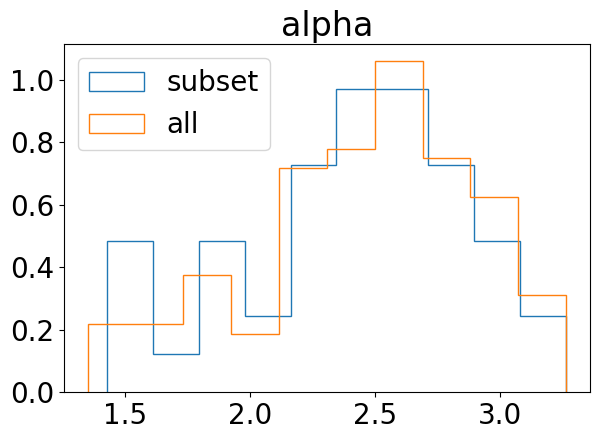

MannwhitneyuResult(statistic=4193.5, pvalue=0.2606697878399038)
0.5848941727805892
0.5491129063153664


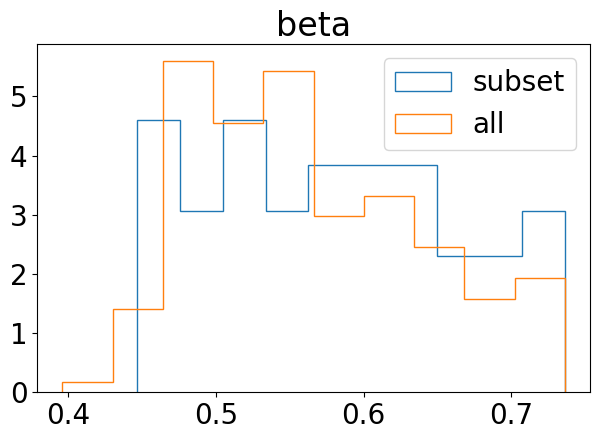

MannwhitneyuResult(statistic=5330.5, pvalue=0.5064196962257612)
85.0
83.0


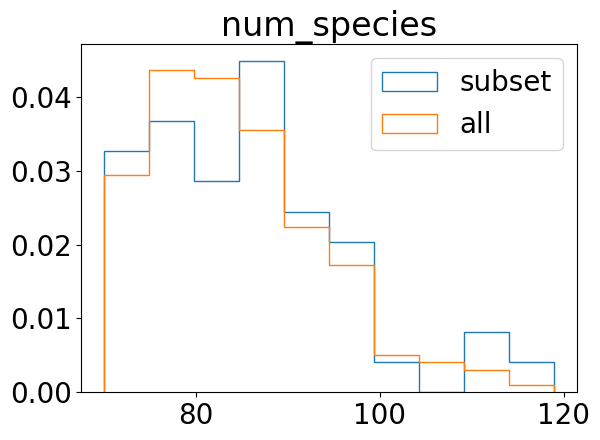

MannwhitneyuResult(statistic=3367.5, pvalue=0.2618258998906646)
3.6525541547061535
4.031073591989328


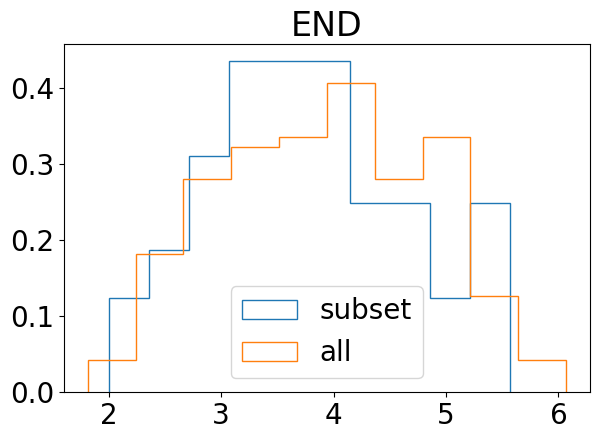

In [10]:
def two_samp_test(dataframe, column):
    x = dataframe[np.isin(dataframe['project'], projects_to_process)][column].values
    y  = dataframe[column].values
    
    x_mask = ~np.isnan(x) 
    x = x[x_mask]
    
    y_mask = ~np.isnan(y)
    y = y[y_mask]
    
    print(sp.stats.mannwhitneyu(x, y))
    print(np.median(x))
    print(np.median(y))
    
    plt.hist(x, histtype='step', density=True, label='subset')
    plt.hist(y, histtype='step', density=True, label='all')
    plt.title(column)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Pictures_for_paper/subset_{column}.pdf', format='pdf')
    plt.show()
    

for column in ['alpha', 'beta', 'num_species', 'END']:
    two_samp_test(mb_small, column)
    

In [5]:
col_label_dict = {
    ### Dimensionality metrics
    # 'END': 'END',
    # 'pr_corrected': 'Participation Ratio (corrected)',
    # 'pr': 'Participation Ratio',
    # 'END_corrected': 'END (corrected)',
    # 'se_corrected': 'Spectrum Entropy (corrected)',
    # 'se': 'Spectrum entropy'
    
    ### Diversity metrics    
    'alpha': 'Shannon Entropy',
    # 'beta': 'Jensen-Shannon Divergence',
    
    ### Niche overlap metrics
    'theta_comp': 'Theta overlap',
    'theta_comp_corrected':'Theta overlap (corrected)',
    'comp': 'Niche Overlap',
    
    ### Generalists metrics
    
    'theta_generalists_pr': 'Theta Generalists PR',
    'theta_generalists_corrected': 'Theta Generalists (corrected)',
    'generalists': 'Generalist ratio',
    
    ### Others
    'log_mean_load': 'Load (log)',
    'mean_removed_load': 'Load (mean removed)',
    'Taylor_slope': 'Taylor\'s Slope',
}

In [20]:
x = 'END'
covar = 'beta'

x_label = 'END'
covar_label = 'Jensen-Shannon Divergence'

for y in col_label_dict:
    y_label = col_label_dict[y]
    
    corr = pg.partial_corr(combined_df, x=x, y=y, method='spearman')
    spearman = corr['r'].values[0]
    pval = corr['p-val'].values[0]
    print(f'{y_label} vs {x_label}')    
    print(f'R: {spearman:.3f}, pval: {pval:.3f}')
    
    corr = pg.partial_corr(combined_df, x=x, y=y, covar=covar, method='spearman')
    spearman = corr['r'].values[0]
    pval = corr['p-val'].values[0]
    print(f'{y_label} vs {x_label} controlled for Beta diversity')    
    print(f'R: {spearman:.3f}, pval: {pval:.3f}')

Shannon Entropy vs END
R: 0.824, pval: 0.000
Shannon Entropy vs END controlled for Beta diversity
R: 0.750, pval: 0.000
Theta overlap vs END
R: 0.738, pval: 0.000
Theta overlap vs END controlled for Beta diversity
R: 0.613, pval: 0.000
Theta overlap (corrected) vs END
R: -0.711, pval: 0.000
Theta overlap (corrected) vs END controlled for Beta diversity
R: -0.570, pval: 0.000
Niche Overlap vs END
R: -0.399, pval: 0.000
Niche Overlap vs END controlled for Beta diversity
R: -0.220, pval: 0.000
Theta Generalists PR vs END
R: 0.107, pval: 0.083
Theta Generalists PR vs END controlled for Beta diversity
R: 0.112, pval: 0.069
Theta Generalists (corrected) vs END
R: 0.110, pval: 0.075
Theta Generalists (corrected) vs END controlled for Beta diversity
R: 0.105, pval: 0.090
Generalist ratio vs END
R: -0.148, pval: 0.017
Generalist ratio vs END controlled for Beta diversity
R: 0.041, pval: 0.513
Load (log) vs END
R: 0.473, pval: 0.000
Load (log) vs END controlled for Beta diversity
R: 0.424, pval:

In [18]:
corr['p-val'].values[0]

2.424576509043906e-66

Spearman R: 0.956, P‑value: 0.000


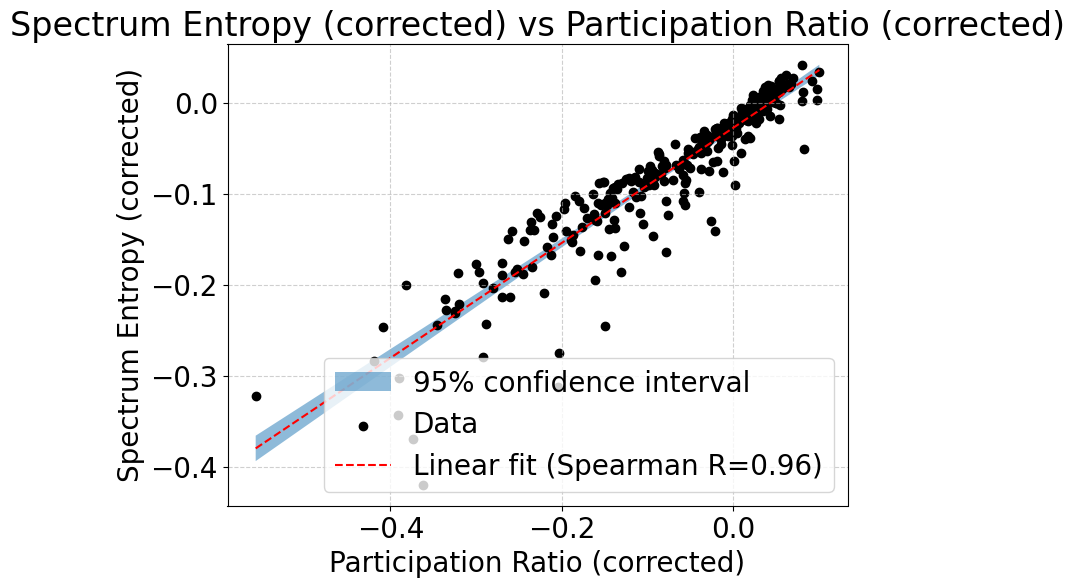

Spearman R: -0.365, P‑value: 0.000


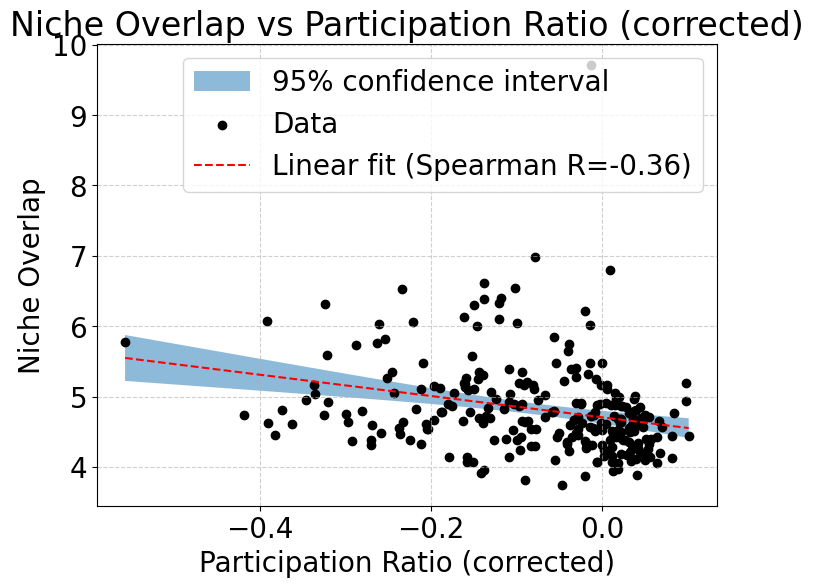

Spearman R: -0.345, P‑value: 0.000


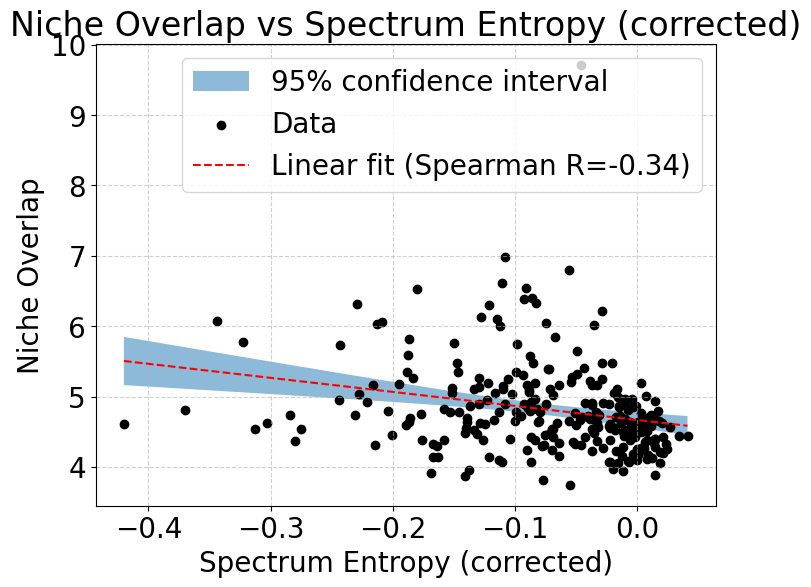

In [ ]:
from itertools import combinations

# assuming combined_df and col_label_dict are already defined, and plot_helper is in scope

for x_col, y_col in combinations(col_label_dict.keys(), 2):
    x = combined_df[x_col]
    y = combined_df[y_col]
    x_label = col_label_dict[x_col]
    y_label = col_label_dict[y_col]
    title   = f"{y_label} vs {x_label}"
    
    plot_helper(
        x, y,
        x_label=x_label,
        y_label=y_label,
        title=title
    )
    plt.savefig(f'/home/ks2823/Microbiomap/Pictures_for_paper/MB_{x_col}_{y_col}.pdf', format='pdf')
    plt.show()

Spearman R: -0.741, P‑value: 0.000


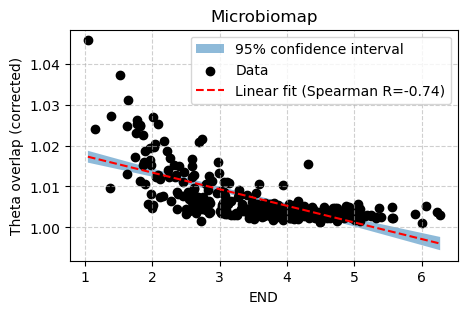

In [44]:
x = combined_df['END']
y = combined_df['theta_comp_corrected']

x_label = 'END'
y_label = 'Theta overlap (corrected)'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.649, P‑value: 0.000


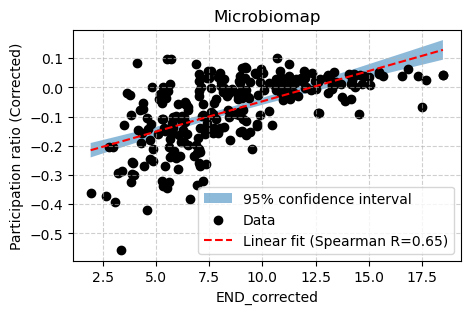

In [60]:
x = combined_df['END_corrected']
y = combined_df['pr_corrected']

x_label = 'END_corrected'
y_label = 'Participation ratio (Corrected)'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.836, P‑value: 0.000


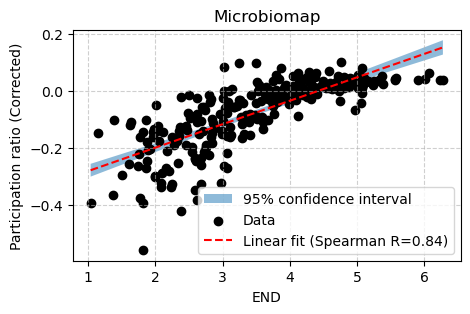

In [61]:
x = combined_df['END']
y = combined_df['pr_corrected']

x_label = 'END'
y_label = 'Participation ratio (Corrected)'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.902, P‑value: 0.000


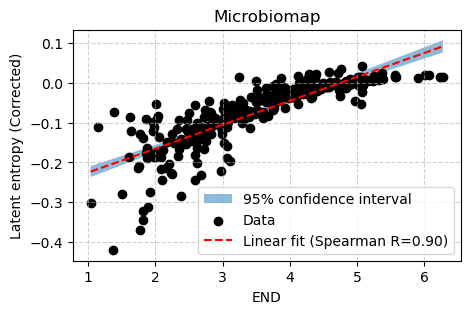

In [62]:
x = combined_df['END']
y = combined_df['se_corrected']

x_label = 'END'
y_label = 'Latent entropy (Corrected)'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.959, P-value: 0.000


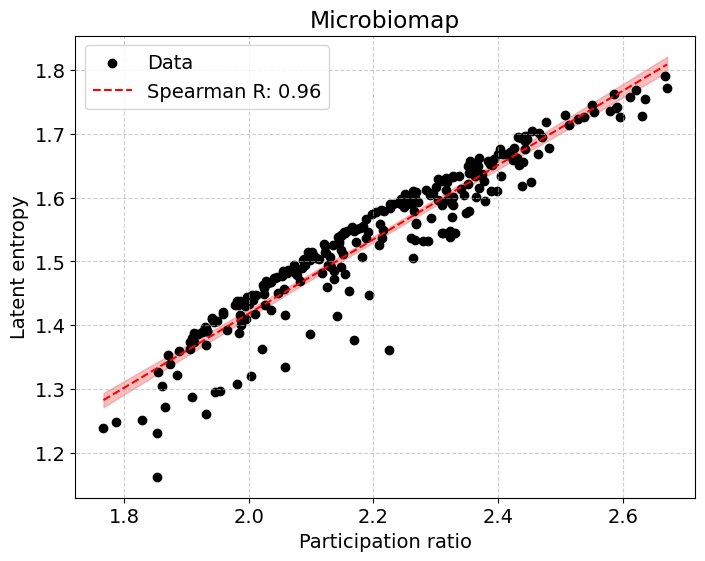

In [9]:
x = combined_df['pr']
y = combined_df['se']

x_label = 'Participation ratio'
y_label = 'Latent entropy'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.954, P-value: 0.000


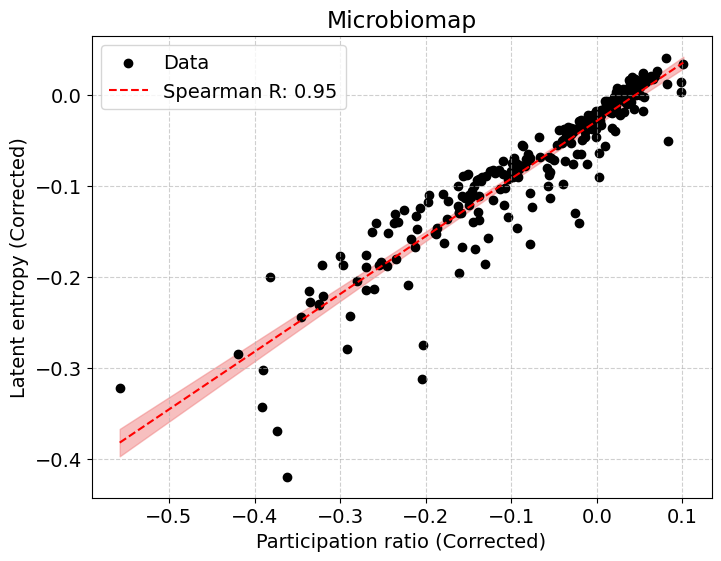

In [8]:
x = combined_df['pr_corrected']
y = combined_df['se_corrected']

x_label = 'Participation ratio (Corrected)'
y_label = 'Latent entropy (Corrected)'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.384, P-value: 0.000


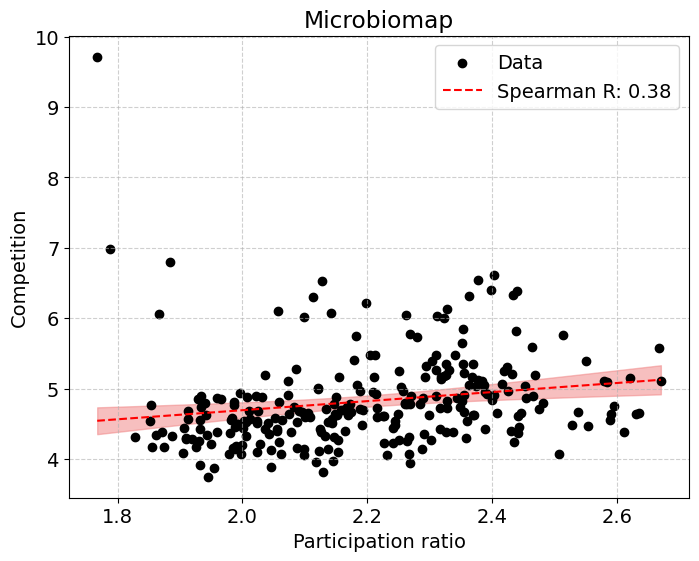

In [10]:
x = combined_df['pr']
y = combined_df['comp']

x_label = 'Participation ratio'
y_label = 'Competition'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: -0.365, P-value: 0.000


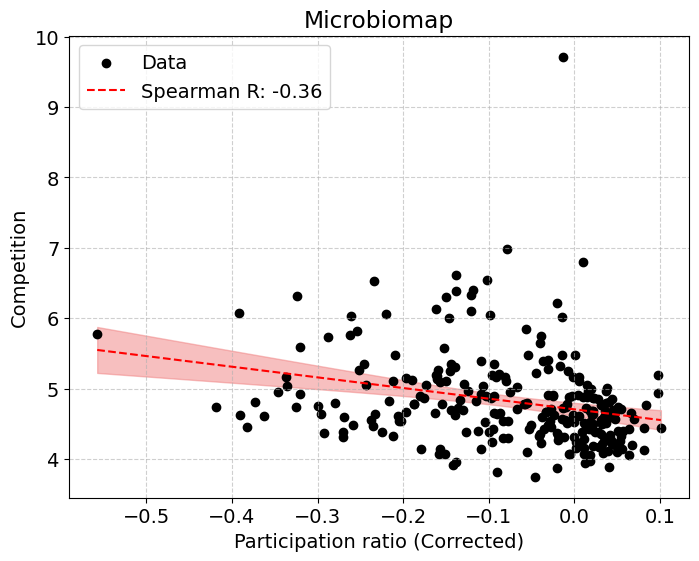

In [12]:
x = combined_df['pr_corrected']
y = combined_df['comp']

x_label = 'Participation ratio (Corrected)'
y_label = 'Competition'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.659, P-value: 0.000


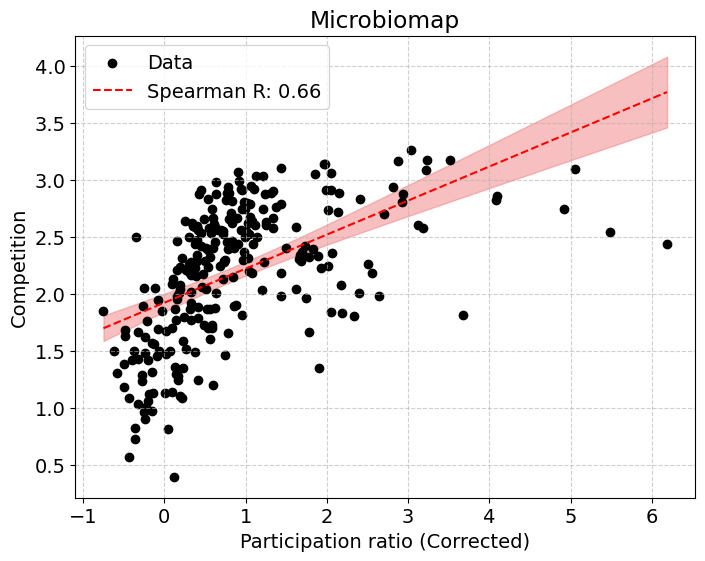

In [36]:
x = combined_df['pr_corrected']
y = combined_df['alpha']

x_label = 'Participation ratio (Corrected)'
y_label = 'Competition'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: -0.110, P-value: 0.075


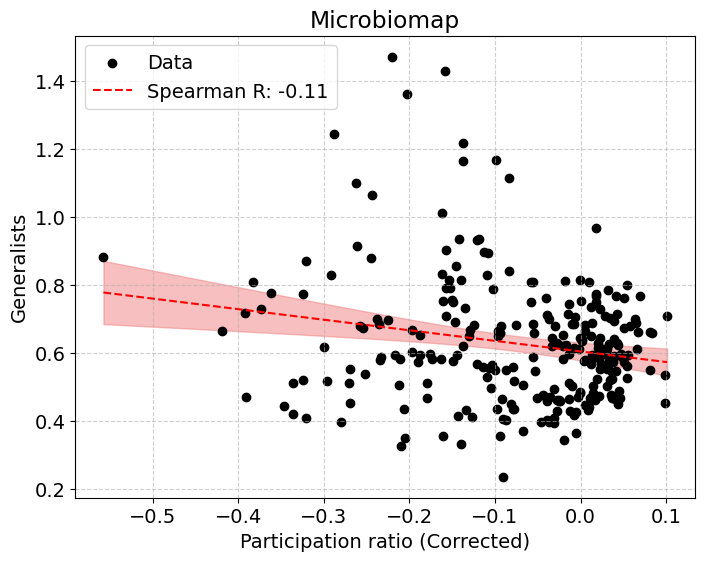

In [ ]:
x = combined_df['pr_corrected']
y = combined_df['generalists']

x_label = 'Participation ratio (Corrected)'
y_label = 'Generalists'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)

Spearman R: 0.903, P-value: 0.000


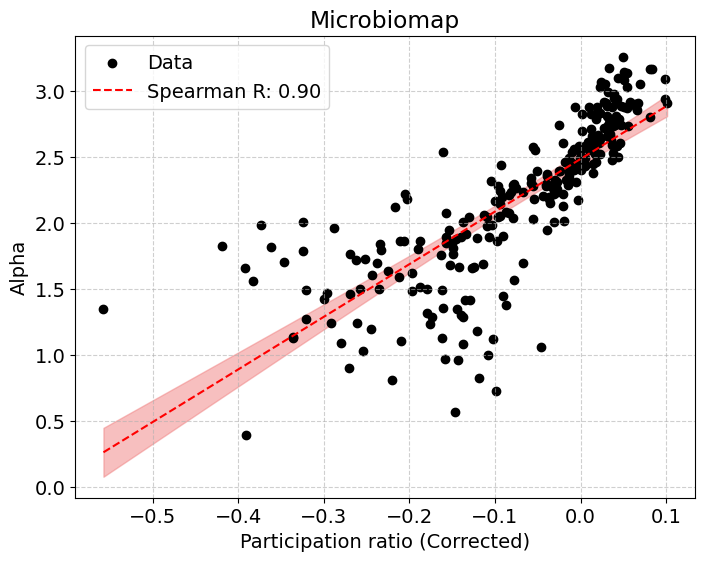

In [14]:
x = combined_df['pr_corrected']
y = combined_df['alpha']

x_label = 'Participation ratio (Corrected)'
y_label = 'Alpha'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)